In [ ]:
#Code snippet for iterating over fields.  Cannot be used for HistDatReq
#for fieldData in fieldDataArray.values():
#    for field in fieldData.elements():
#        response[secName][field.name()] = field.getValue()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 30 14:13:28 2016

@author: 4126694
"""

import blpapi
import pandas as pd
import csv
import bt
import matplotlib.pyplot as plt
import numpy as np

options = blpapi.SessionOptions()
options.setServerHost('localhost')
options.setServerPort(8194)

SECURITY_DATA = blpapi.Name("securityData")
DATE = blpapi.Name("date")
SECURITY = blpapi.Name("security")
FIELD_DATA = blpapi.Name("fieldData")
START_DT = blpapi.Name("startDate")
END_DT = blpapi.Name("endDate")
PERIODICITY = blpapi.Name("periodicitySelection")
SECURITY_DES = blpapi.Name("Security Description")

def getHist (sec_list, fld_list, start_date, end_date):
    session = blpapi.Session(options)
    session.start()
    session.openService('//blp/refdata')
    refDataService = session.getService("//blp/refdata")
    request = refDataService.createRequest("HistoricalDataRequest")
    for s in sec_list:
        request.append("securities",s)
    for f in fld_list:
        request.append("fields",f)
    request.set("startDate", start_date)
    request.set("endDate", end_date)
    request.set("periodicitySelection", "DAILY");
    session.sendRequest(request)
    try:
        response = {}
        # Process received events
        while(True):
            # We provide timeout to give the chance to Ctrl+C handling:
            ev = session.nextEvent(500)
            for msg in ev:
                if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:                    
                    securityData = msg.getElement(SECURITY_DATA)
                    secName = securityData.getElementAsString(SECURITY)
                    
                    fieldDataArray = securityData.getElement(FIELD_DATA)
                    response[secName] = {}
                    for num in range(fieldDataArray.numValues()):
                        tradedate = fieldDataArray.getValue(num).getElement(DATE).getValue()
                        close_px = fieldDataArray.getValue(num).getElement("PX_LAST").getValue()
                        response[secName][tradedate] = close_px
                                      
            # Response completely received, so we could exit
            
            if ev.eventType() == blpapi.Event.RESPONSE:
                break
    finally:
        # Stop the session
        session.stop()
        
    tempdict = {}
    for r in response:
        tempdict[r] = pd.Series(response[r])
        
    data = pd.DataFrame(tempdict)
    return data
                

sec = ["7269 JP Equity","7202 JP Equity"]
fld = ["PX_LAST"]
sd = "20060328"
ed = "20160329"
data = getHist(sec,fld,sd,ed)
change = data.pct_change()
plot = bt.merge(data).plot(figsize=(15, 5))
plt.show()

In [ ]:
chg_lng = change[['7269 JP Equity']]
chg_sht = change[['7202 JP Equity']]
chg_lng.dropna()
chg_sht.dropna()
ratio = pd.DataFrame(data[[1]].values/data[[0]].values, index=data[[1]].index, columns=[sec[0][0:4] \
                                                                    + '/' + sec[1][0:4] + ' ratio'])
Z_ratio = (ratio - ratio.mean())/ratio.std()
plot = bt.merge(ratio).plot(figsize=(15, 5))
Z_ratio.hist(bins=50)
plt.show()

Need to compute rolling average mean and stdev to avoid lookahead bias
Also apply cointegration test

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 04 10:22:50 2016

@author: 4126694
"""

# IntradayTickExample.py

import blpapi
import copy
import datetime
import pandas as pd
import bt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


options = blpapi.SessionOptions()
options.setServerHost('localhost')
options.setServerPort(8194)

TICK_DATA = blpapi.Name("tickData")
COND_CODE = blpapi.Name("conditionCodes")
TICK_SIZE = blpapi.Name("size")
TIME = blpapi.Name("time")
TYPE = blpapi.Name("type")
VALUE = blpapi.Name("value")
RESPONSE_ERROR = blpapi.Name("responseError")
CATEGORY = blpapi.Name("category")
MESSAGE = blpapi.Name("message")
SESSION_TERMINATED = blpapi.Name("SessionTerminated")

UTC_OFFSET = datetime.datetime.utcnow() - datetime.datetime.now()



def getTicks(sec_list, event_list, sdtime, edtime):
      
    session = blpapi.Session(options)
    session.start()
    session.openService('//blp/refdata')
    refDataService = session.getService("//blp/refdata")
    request = refDataService.createRequest("IntradayTickRequest")
    
    for s in sec_list:
        request.set("security", s)
    for ev in event_list:
        request.append("eventTypes",ev)  
    
    # Convert DateTimeString to UTC datetime object
    fmt = "%Y-%m-%d" + 'T' + "%H:%M:%S"  #Assumes no milliseconds
    startDateTime = datetime.datetime.strptime(sdtime, fmt) + UTC_OFFSET
    endDateTime = datetime.datetime.strptime(edtime, fmt) + UTC_OFFSET
        
    request.set("startDateTime", startDateTime)
    request.set("endDateTime", endDateTime)

    #print "Sending Request:", request
    session.sendRequest(request)
    
    try:
        # Process received events
        while(True):
            # We provide timeout to give the chance to Ctrl+C handling:
            ev = session.nextEvent(500)
            
            indexlist = []
            typelist = []
            pricelist = []
            sizelist = []
            
            #output = pd.Dataframe()
            
            for msg in ev:
                if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:                    
                    data = msg.getElement(TICK_DATA).getElement(TICK_DATA)
                    secName = s
                    for item in data.values():
                        time = item.getElementAsDatetime(TIME)
                        time = time - UTC_OFFSET
                        timeString = item.getElementAsString(TIME)
                        type = item.getElementAsString(TYPE)
                        value = item.getElementAsFloat(VALUE)
                        size = item.getElementAsInteger(TICK_SIZE)
                        
                        indexlist.append(time)
                        typelist.append(type)
                        pricelist.append(value)
                        sizelist.append(size)
                        
            # Response completely received, so we could exit
            
            if ev.eventType() == blpapi.Event.RESPONSE:
                break
    finally:
        # Stop the session
        session.stop()
    
    output = pd.DataFrame({'size': sizelist,
                               'price': pricelist,
                               'type': typelist, }, index=indexlist)
    
    return output
    
sec = ["4901 JP Equity"]
fld = ["TRADE","BID","ASK"]
sd = "2016-04-04T09:00:00"
ed = "2016-04-04T09:10:00"
data = getTicks(sec,fld,sd,ed)
data.head()
#plot = bt.merge(data).plot(figsize=(15, 5))
#plt.show()

,price,size,type
2016-04-04,4264,51300,BID
2016-04-04,4265,52500,ASK
2016-04-04,4265,51200,BID
2016-04-04,4266,53100,ASK
2016-04-04,4265,51200,BID


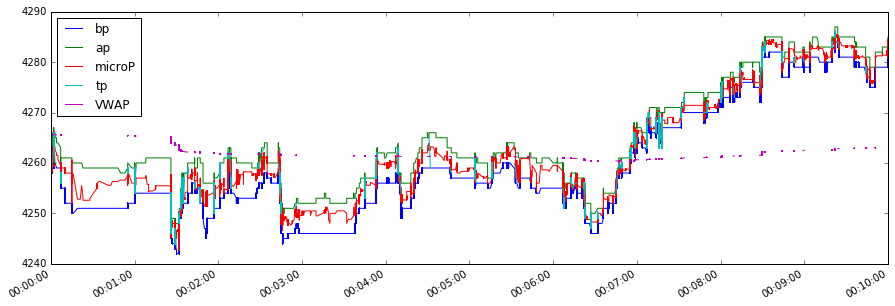

In [16]:
data_trade = data[(data.type == 'TRADE')]
data_bid = data[(data.type == 'BID')]
data_ask = data[(data.type == 'ASK')]
data_trade['Value'] = data_trade['price'] * data_trade['size'] 
data_trade['VWAP'] = data_trade['Value'].cumsum() / data_trade['size'].cumsum()
data_trade.columns =['tp','ts','type','value','VWAP']
data_bid.columns =['bp','bs','type']
data_ask.columns =['ap','as','type']
data_ask.pop('type')
data_bid.pop('type')
data_trade.pop('type')
data_ba=data_ask.join(data_bid)
data_ba['microP'] = data_ba['bp']*( data_ba['as']/(data_ba['as'] +data_ba['bs'])) + \
                    data_ba['ap']*( data_ba['bs']/(data_ba['as'] +data_ba['bs']))
data_ba = data_ba.join(data_trade,how="outer")
#plot = bt.merge(data_ba.bp,data_ba.ap,data_ba.microP,data_ba.tp,data_ba.VWAP).plot(figsize=(15, 5))
#plt.show()

In [7]:
plot = bt.merge(data_ba.microP,data_ba.tp).plot(figsize=(15, 5))
plt.show()

In [12]:
%matplotlib inline